c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\scipy\stats\_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\scipy\stats\_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


(0.0, 0.703, 0.703)
(0.0, 0.709, 0.709)
(0.0, 0.705, 0.705)
(0.0, 0.726, 0.726)
(0.0, 0.727, 0.727)
(0.0, 0.704, 0.704)
(0.0, 0.697, 0.697)


c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


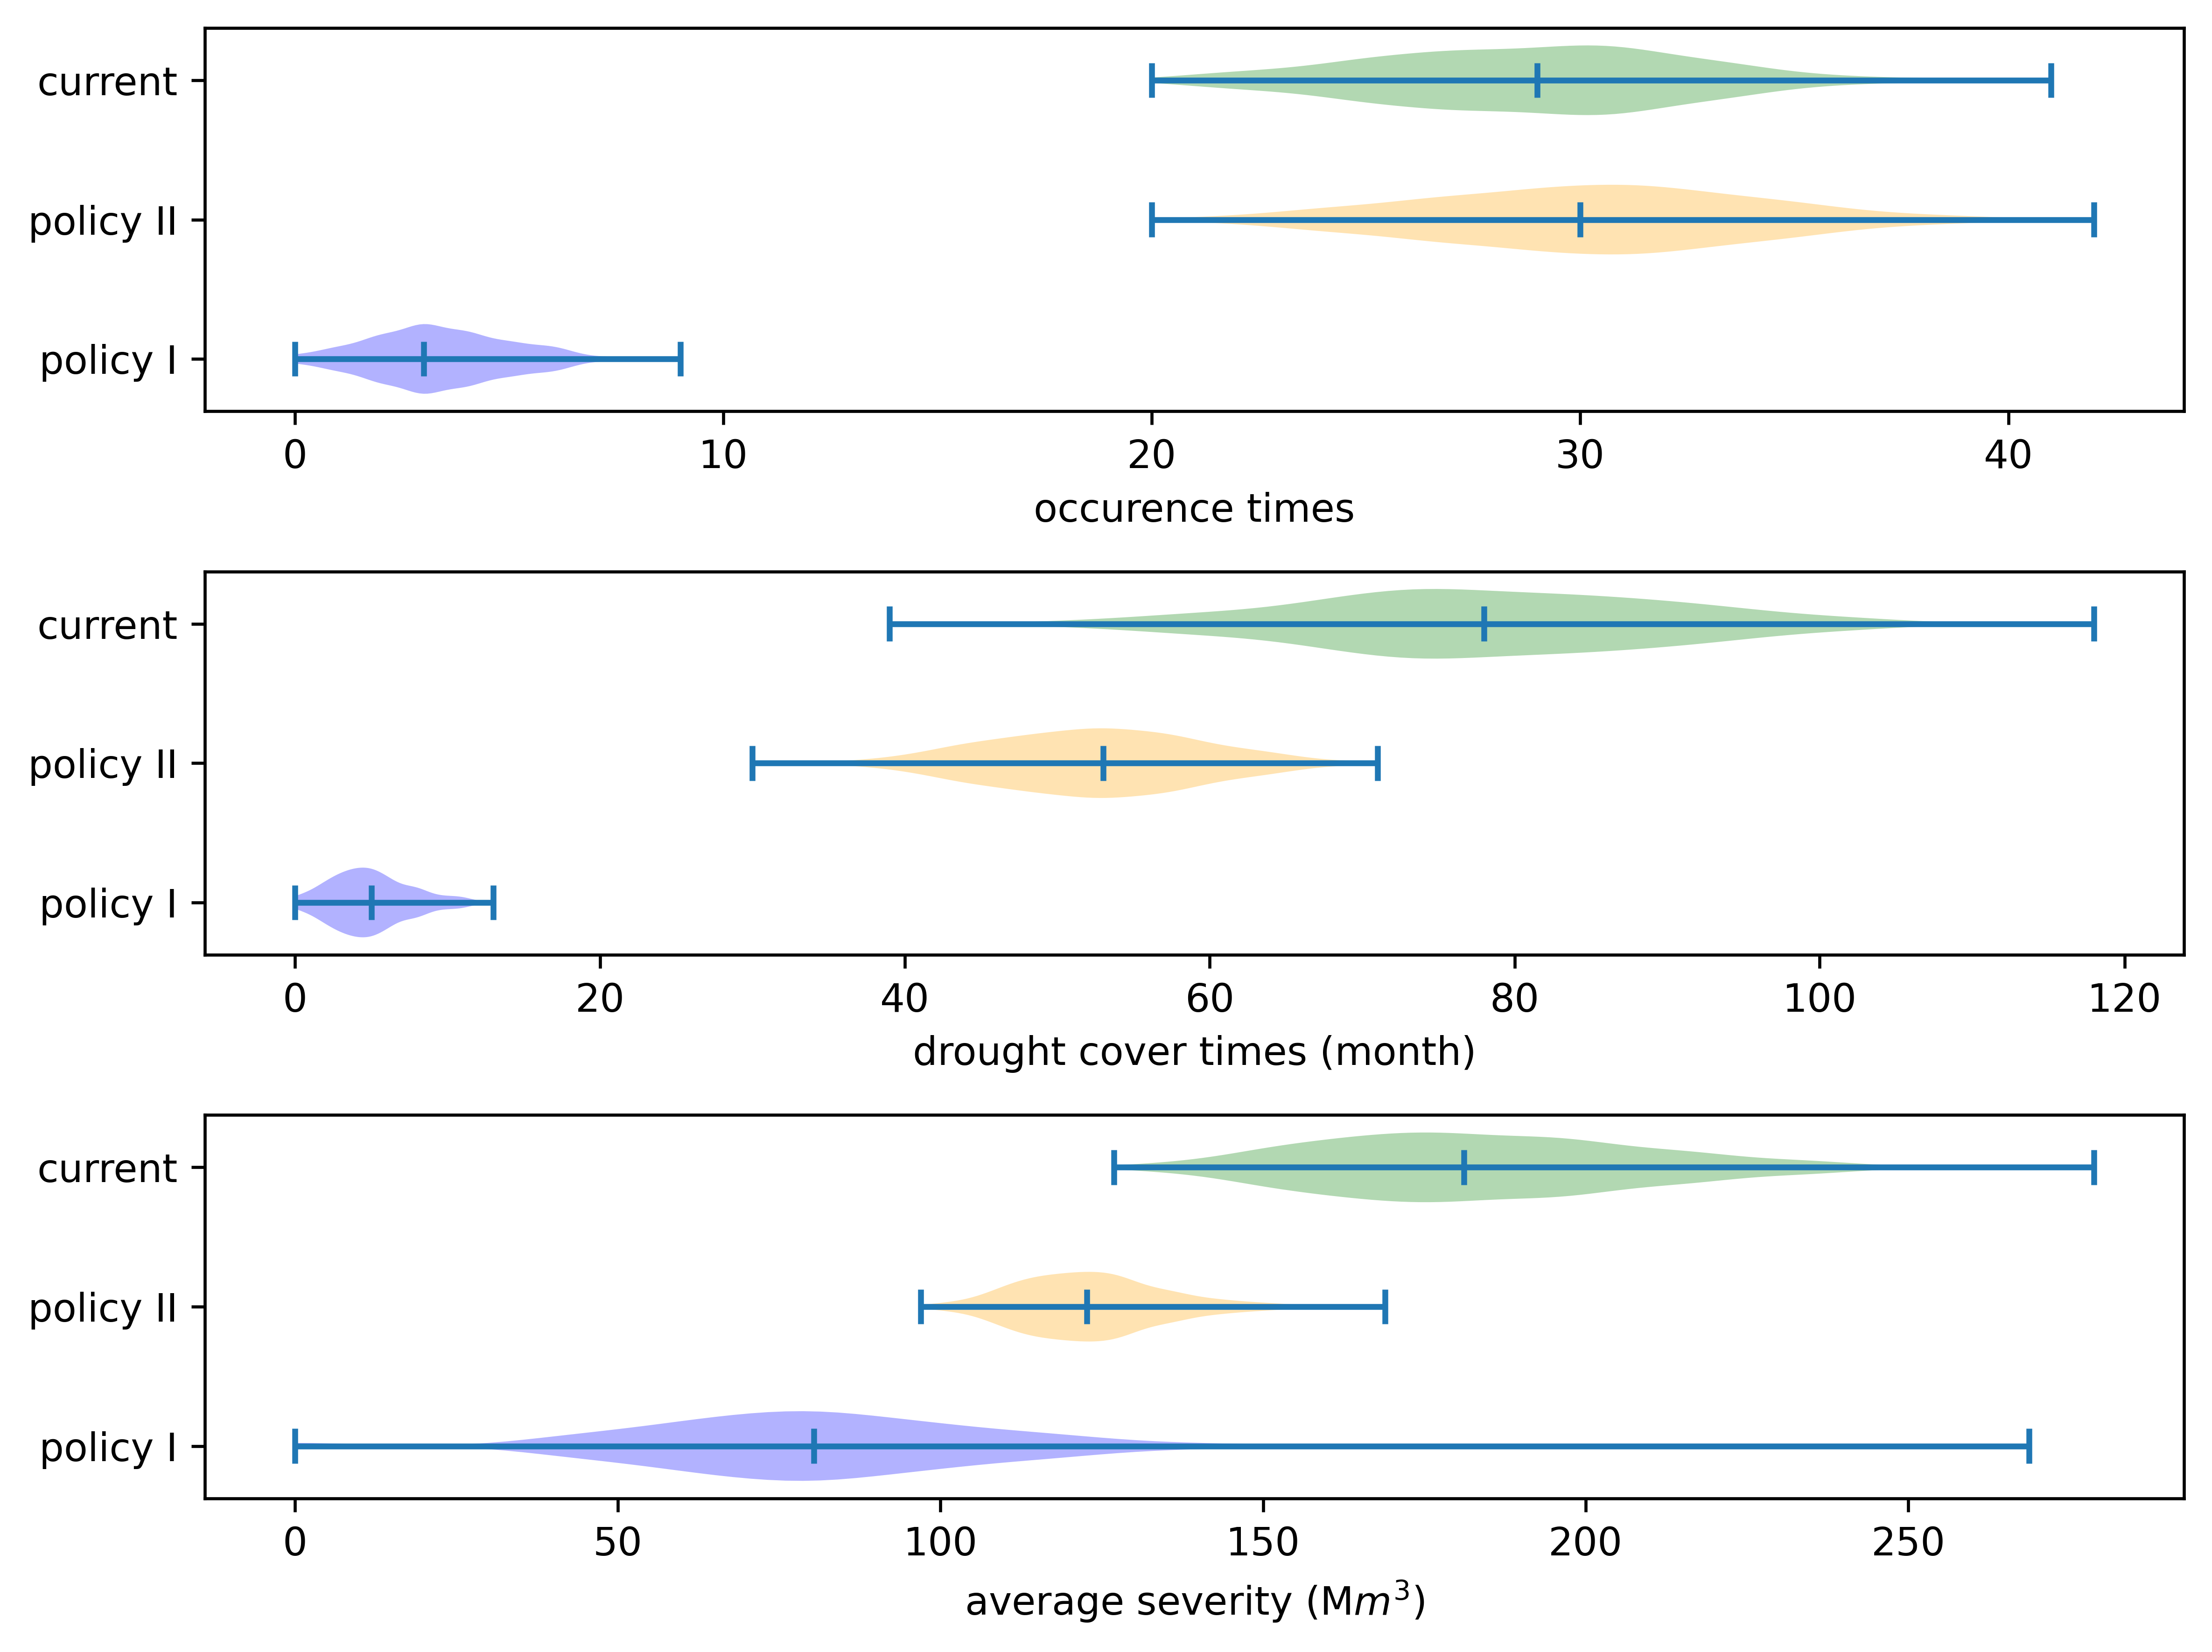

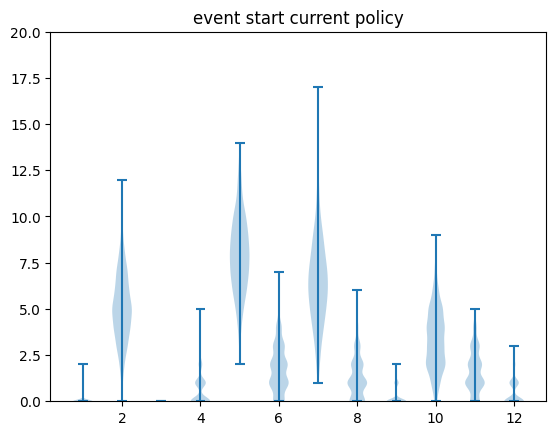

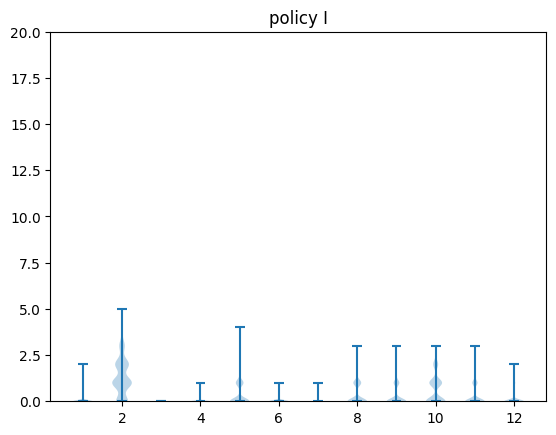

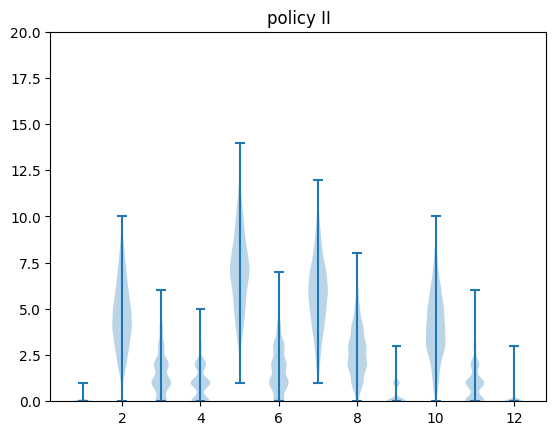

In [1]:
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import learn_ar_model as lm
from matplotlib import gridspec

file_path_data_sheet = './data/data_sheet.xlsx'
file_path_tem = './data/石門站溫度資料.txt'
file_path_total_data = './data/石門水庫雨量與流量資料.xlsx'
file_path_ar = './data/日雨量溫度資料.xlsx'
file_path_riskmap_p = "./data/"
risk_map = lm.annual_riskmap
consumption_limit = 1500
max_storage = 3000
min_storage = 150
resolution = 20
discount_factors = [0.215, 0.465, 0.681]

df_r = lm.dual_system.read_data.get_storage_correction_inflow_consum_dataframe()

def model_setting(consumption_limit, max_storage, min_storage, resolution):
    consumption_array = np.zeros(shape = resolution)
    storage_array = np.zeros(shape = resolution)
    c_step = consumption_limit / resolution
    s_step = (max_storage - min_storage) / resolution        
    
    for i in range(resolution):
        consumption_array[i] = c_step * (i + 1)
        storage_array[i] = min_storage + s_step * i

    return consumption_array, storage_array

model_set = model_setting(consumption_limit, max_storage, min_storage, resolution)

def get_demand(file_path_data_sheet):
    data_frame = pd.DataFrame(pd.read_excel(file_path_data_sheet))
    date_series = pd.Series(data_frame["date_month"])
    
    c_series = pd.Series(data_frame["total_consumption"])
    record = pd.Series(data_frame["drought_record"])
    
    dataframe_1 = pd.DataFrame()
    dataframe_1.insert(loc = 0, column = "date", value = date_series)
    dataframe_1.insert(loc = 1, column = "C", value = c_series)
    dataframe_1.insert(loc = 2, column = "record", value = record)
    dataframe_1 = dataframe_1.dropna(thresh = 1)
    
    month_demand = np.zeros(shape = [12, 1])
    month_count = np.zeros(shape = [12, 1])
    
    for i in range(len(dataframe_1)):
        for j in range(len(month_demand)):
            if j + 1 == dataframe_1["date"][i].month:
                if dataframe_1["record"][i] != 1:
                    month_demand[j] = month_demand[j] + dataframe_1["C"][i]
                    month_count[j] = month_count[j] + 1
                else:
                    continue
    return (month_demand/ month_count).reshape([12]) * 1.1

demand_list = get_demand(file_path_data_sheet)

def get_annual_risk_map(consumption_limit, 
                        max_storage,
                        min_storage, 
                        resolution):
    output = []
    for i in range(12):
        temp = lm.dual_system.get_seasonal_risk_map(i+1,
                                                    consumption_limit, 
                                                    max_storage, 
                                                    min_storage, 
                                                    resolution)[2]
        temp = np.rot90(temp.T)
        output.append(temp)
    return np.array(output)

def get_policy(policy_name):
    file_path = file_path_riskmap_p + "/policy/" + policy_name + ".npy"
    output = np.load(file_path)
    return output
            
class env_setting:
    
    def __init__(self, annual_risk_map, model_set, initial_storage, 
                 initial_month, demand_list):
        
        self.consumptions = model_set[0]
        self.storages = model_set[1]
        self.annual_risk_map = annual_risk_map
        self.statecount = len(model_set[0])*len(model_set[1])
        self.actioncount = len(self.consumptions)
        self.initial_storage = initial_storage
        self.initial_month = initial_month
        self.demand_list = demand_list
        
        es_expect_list = []
        for i in range(12):
            es_expect_list.append(self.es_expected_value(i+1))
        
        self.es_expect_array = np.array(es_expect_list)
        
        inflow_expect_list = []
        for i in range(12):
            inflow_expect_list.append(self.inflow_expected_value(i+1))
        
        self.inflow_expect_array = np.array(inflow_expect_list)
        self.correct_array = lm.dual_system.storage_correct_array
        self.capacity = lm.dual_system.storage_capacity
        self.s_to_correct_params = lm.dual_system.regress_s_to_correction
        self.noise_distribution_list = lm.dual_system.noise_distribution_list
        self.inflow_to_discharge_params = lm.dual_system.discharge_regress_inflow
        self.inflow_to_discharge_noise_distribution_list = lm.dual_system.discharge_noise_distribution_list
        
    
    def random_correct_noise(self, month, noise_distribution_list):
   
        name =  noise_distribution_list[month - 1][0]
        params = noise_distribution_list[month - 1][1]
       
        if name == 'norm':
        
            noise = st.norm.rvs(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            noise = st.gamma.rvs(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            noise = st.gumbel_r.rvs(loc = params[0], scale = params[1])
            
        elif name == 'gumbel_l':
            
            noise = st.gumbel_l.rvs(loc = params[0], scale = params[1])     
        
        elif name == 'lognorm':

            noise = st.lognorm.rvs(s = params[0], loc = params[1], scale = params[2])          

        elif name == 'pearson3':

            noise = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            noise = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])          

        return noise    
    
    def storage_change_correction(self, month, inflow):
        
        slope, intercept = self.s_to_correct_params[month - 1]
        noise = self.random_correct_noise(month, self.noise_distribution_list)
        
        return (inflow * slope + intercept  + noise)

    def discharge_simulation(self, month, inflow):
        
        slope, intercept = self.inflow_to_discharge_params[month - 1]
        noise = self.random_correct_noise(month, self.inflow_to_discharge_noise_distribution_list)
        
        return abs(inflow * slope + intercept  + noise)

    def es_expected_value(self, month):
        
        name = lm.dual_system.es_s_dis_list[month - 1][0]
        params = lm.dual_system.es_s_dis_list[month - 1][1]
        
        if name == 'norm':
        
            es = st.norm.mean(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            es = st.gamma.mean(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            es = st.gumbel_r.mean(loc = params[0], scale = params[1])    
      
        elif name == 'gumbel_l':
            
            es = st.gumbel_l.mean(loc = params[0], scale = params[1])        
        
        elif name == 'lognorm':

            es = st.lognorm.mean(s = params[0], loc = params[1], scale = params[2])          
        
        elif name == 'pearson3':

            es = st.pearson3.mean(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            es = st.loggamma.mean(c = params[0], loc = params[1], scale = params[2])          
    
        
        return max(es, 0)
   
    def inflow_expected_value(self, month):
        
        name = lm.dual_system.inflow_s_dis_list[month - 1][0]
        params = lm.dual_system.inflow_s_dis_list[month - 1][1]
        
        if name == 'norm':
        
            inflow = st.norm.mean(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            inflow = st.gamma.mean(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            inflow = st.gumbel_r.mean(loc = params[0], scale = params[1])    
      
        elif name == 'gumbel_l':
            
            inflow = st.gumbel_l.mean(loc = params[0], scale = params[1])        
        
        elif name == 'lognorm':

            inflow = st.lognorm.mean(s = params[0], loc = params[1], scale = params[2])          
        
        elif name == 'pearson3':

            inflow = st.pearson3.mean(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            inflow = st.loggamma.mean(c = params[0], loc = params[1], scale = params[2])          
    
        return max(inflow, 0)

# The potential supply capacity is the measurement to evaluate
# water resource value in dual system. The counter shortage is maximum 

    def storage_update(self, month, pre_storage, consumption, inflow, change_correct
                       , discharge):
        capacity = self.capacity
        real_consumption = min(pre_storage + inflow + change_correct, consumption)
# =============================================================================
#         real_discharge = min(pre_storage + inflow - real_consumption + change_correct, discharge)
# =============================================================================
        
        if pre_storage + inflow - real_consumption - discharge + change_correct > capacity:
            return max(capacity, 0 )
        
        else:
            return max(pre_storage + inflow - real_consumption - discharge + change_correct, 0)

    def random_inflow(self, month):
   
        name =  lm.dual_system.inflow_s_dis_list[month - 1][0]
        params = lm.dual_system.inflow_s_dis_list[month - 1][1]
       
        if name == 'norm':
        
            inflow = st.norm.rvs(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            inflow = st.gamma.rvs(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            inflow = st.gumbel_r.rvs(loc = params[0], scale = params[1])
            
        elif name == 'gumbel_l':
            
            inflow = st.gumbel_l.rvs(loc = params[0], scale = params[1])     
        
        elif name == 'lognorm':

            inflow = st.lognorm.rvs(s = params[0], loc = params[1], scale = params[2])          

        elif name == 'pearson3':

            inflow = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            inflow = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])          

        return inflow


    def random_es(self, month):
   
        name =  lm.dual_system.es_s_dis_list[month - 1][0]
        params = lm.dual_system.es_s_dis_list[month - 1][1]
       
        if name == 'norm':
        
            es = st.norm.rvs(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            es = st.gamma.rvs(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            es = st.gumbel_r.rvs(loc = params[0], scale = params[1])
            
        elif name == 'gumbel_l':
            
            es = st.gumbel_l.rvs(loc = params[0], scale = params[1])     
        
        elif name == 'lognorm':

            es = st.lognorm.rvs(s = params[0], loc = params[1], scale = params[2])          

        elif name == 'pearson3':

            es = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            es = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])          

        return es

    
    def randant_choice(self, storage, inflow, month):
        
        consumption_boundary = max(storage + inflow, 0)
        max_indice = np.argmin(abs(consumption_boundary - self.consumptions))
        
        return np.random.choice(self.consumptions[range(max_indice + 1)])
        
    def reset(self):
        
        initial_indice_s = np.argmin(abs(self.initial_storage - self.storages))
        es = self.random_es(self.initial_month)
        inflow = self.random_inflow(self.initial_month)

        return  self.storages[initial_indice_s], self.initial_month, inflow, es

    def reset_random(self):
        
        initial_indice_s = np.random.choice(range(20))
        es = self.random_es(self.initial_month)
        inflow = self.random_inflow(self.initial_month)
        change_correct = self.storage_change_correction(self.initial_month,
                                                        inflow)
        discharge = self.discharge_simulation(self.initial_month, inflow)
        
        return  self.storages[initial_indice_s], self.initial_month, inflow, es , discharge, change_correct 

    def step_update_mdp(self, consumption, storage, month, reward_type = 0):
        
        threshold = lm.dual_system.rfd_threshold[month - 1]
        inflow = self.random_inflow(month)
        es = self.random_es(month)
        discharge = self.discharge_simulation(month, inflow)
        change_correct = self.storage_change_correction(month, inflow)
        demand = self.demand_list[month - 1]
        real_consumption = max(min(storage + inflow + change_correct, consumption), 0)
# =============================================================================
#         real_discharge = min(storage + inflow - real_consumption + change_correct, discharge)
# =============================================================================
        
        next_storage = self.storage_update(month, storage,
                                           real_consumption,
                                           inflow, change_correct, 
                                           discharge)
        storage_state = (storage + next_storage)/2
     
        cta = lm.dual_system.dual_system_update.get_cta_mdp(real_consumption, inflow, storage_state)
        wdi = lm.dual_system.dual_system_update.get_WDI_mdp(cta)
        rfd = lm.dual_system.dual_system_update.get_RFD_mdp(real_consumption, wdi, es, month)
        
        def get_next_month(month):
            
            if month % 12 == 0:
                
                return 12
            
            else:
                
                return month % 12
        
        next_month = get_next_month(month + 1)        
        reward = 0
        
        if reward_type == 0:
            if rfd >= threshold and wdi > 0.85:
                reward = 0
            else:
                reward = real_consumption
        
        elif reward_type == 1:
            
            reward = (1 - abs((demand - real_consumption) / demand)) * demand
# =============================================================================
#              reward = abs(demand / (demand - real_consumption + 1)) * demand
# =============================================================================

        output_state = (inflow, es, discharge, change_correct)
        return next_storage, reward, real_consumption, storage_state, next_month, output_state     
   
class Q_learning:
    
    def __init__(self, epochs, count_step, eplison, decay, learning_rate
                 ,annual_risk_map, model_set, initial_storage, initial_month, 
                 discount_factor, demand_list):
        
        self.epochs = epochs
        self.count_step = count_step
        self.eplison = eplison
        self.decay = decay
        self.env = env_setting(annual_risk_map, 
                               model_set, 
                               initial_storage, 
                               initial_month,
                               demand_list
                               )

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.storage_elimit = lm.dual_system.dual_system_update.storage_elow_bond
        self.storage_limit = lm.dual_system.dual_system_update.storage_low_bond
        
    def initial_annual_q_table(self, model_set):
        
        annual_q_table = []
        
        for i in range(12):
            
#            q_table = 0.1*st.uniform.rvs(size = [len(model_set[1]), len(model_set[0])])
            q_table = np.zeros(shape = [len(model_set[1]), len(model_set[0])])
            annual_q_table.append(q_table)
        
        return np.array(annual_q_table)

    def count_annual_table(self, model_set):
        
        annual_q_table = []
        
        for i in range(12):
            
            q_table = np.zeros(shape = [len(model_set[1]), len(model_set[0])])
            annual_q_table.append(q_table)
        
        return np.array(annual_q_table)

    def consumption_indice(self, consumption):
        
        return np.argmin(abs(consumption - self.env.consumptions))

    def storage_indice(self, storage):
        
        return np.argmin(abs(storage - self.env.storages))

    def inflow_ppf(self, month, p):
   
        name =  lm.dual_system.inflow_s_dis_list[month - 1][0]
        params = lm.dual_system.inflow_s_dis_list[month - 1][1]
       
        if name == 'norm':
        
            inflow = st.norm.ppf(q = p,loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            inflow = st.gamma.ppf(q = p, a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            inflow = st.gumbel_r.ppf(q = p,loc = params[0], scale = params[1])
            
        elif name == 'gumbel_l':
            
            inflow = st.gumbel_l.ppf(q = p,loc = params[0], scale = params[1])     
        
        elif name == 'lognorm':

            inflow = st.lognorm.ppf(q = p,s = params[0], loc = params[1], scale = params[2])          

        elif name == 'pearson3':

            inflow = st.pearson3.ppf(q = p,skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            inflow = st.pearson3.ppf(q = p,kew = params[0], loc = params[1], scale = params[2])          

        return inflow

    def policy_during_water_deficit(self, month, water_storage, p_value = 0.02):
        
        inflow_p = self.inflow_ppf(month, p_value)
        threshold = lm.dual_system.rfd_threshold[int(month - 1)]
        bier = lm.dual_system.bier[int(month - 1)]
        robustness = lm.dual_system.resilience
        cwdi_limit = 0.85
        expected_e = self.env.es_expect_array[int(month-1)]
        
        coeff_cwdi_limit = np.log(99*cwdi_limit/(1-cwdi_limit))/robustness
        const_rfd_limit = expected_e * bier
        
        c_cwdi = coeff_cwdi_limit * (inflow_p + 2 * water_storage)
        c_rfd = threshold / cwdi_limit + const_rfd_limit
        
        sensitivity = [0,0] # [cwdi, rfd]
        
        if c_cwdi <= c_rfd:
            sensitivity = np.array([1,0])
            criteria = np.array([c_cwdi, c_rfd])
        
        else:
            sensitivity = [0,1]
            criteria = np.array([c_rfd, c_cwdi]) 
        
        return min(c_cwdi, c_rfd), sensitivity, criteria


    def training_mdp(self, reward_type = 0):
        
        annual_q_table = self.initial_annual_q_table(model_set)
        step = 0
        annual_count = self.count_annual_table(model_set)
        loss_array = np.zeros(shape = self.count_step * self.epochs + 1)
        flags = np.zeros(12)
        flags_count = np.zeros(12)
        
        def get_month_indice(month):
            
            if month % 12 == 0:
                return 11
            
            else:
                return month % 12 - 1
        
        annual_reward_list = [[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1]]
        
        for i in range(self.epochs):
            if np.sum(flags) >= 12:
                print("reach terminal conditins")
                break
            for k in range(12):
                if step > len(annual_reward_list[k]):
                    flags_count[k] += 1
                if flags_count[k] >= 10:
                    flags[k] = 1
        
            storage, month, inflow, es, discharge, change_correct = self.env.reset_random()
            eplison = self.eplison * self.decay ** (i)

            while step < self.count_step* self.epochs:
                
                temp_learning_rate = self.learning_rate / (1 + step / 4800)
                annual_reward_list[month - 1].append(np.sum(annual_q_table[month - 1]))    
                storage_elimit = self.storage_elimit[int(month - 1)]
                storage_limit = self.storage_limit[int(month - 1)]                
                step += 1
                q_table = annual_q_table[get_month_indice(month)]
                q_table_next = annual_q_table[get_month_indice(month + 1)]
                s_i = self.storage_indice(storage)
                count_table = annual_count[get_month_indice(month)]
                consumption_boundary = max(storage + inflow + change_correct, 0)
                c_i_boundary = np.argmin(abs(consumption_boundary - self.env.consumptions))
                
                if storage < storage_elimit:
                    consumption_elimit = self.policy_during_water_deficit(month, storage)[0]
                    c_i = np.argmin(abs(consumption_elimit - self.env.consumptions))
                    c_i = min(c_i, c_i_boundary)
                    consumption = self.env.consumptions[c_i]
                
                elif storage < storage_limit and storage > storage_elimit:
                    consumption_limit = self.policy_during_water_deficit(month, storage, p_value = 0.15)[0]
                    c_i = np.argmin(abs(consumption_limit - self.env.consumptions))
                    c_i = min(c_i, c_i_boundary)
                    consumption = self.env.consumptions[c_i]                  
                    
                else:
                    if np.random.uniform() < eplison:
                        consumption = self.env.randant_choice(inflow, storage, month)
                        c_i = self.consumption_indice(consumption)
                
                    else:
                        c_i = min(np.argmax(q_table[s_i]), c_i_boundary)
                        consumption = self.env.consumptions[c_i]
                
                next_storage, reward, consumption, storage_state, next_month, output_state = self.env.step_update_mdp(consumption, 
                                                                                           storage, 
                                                                                           month,
                                                                                           reward_type = reward_type)
                inflow = output_state[0]
                change_correct = output_state[3]
                n_s_i = self.storage_indice(next_storage)

                temp_record = q_table[s_i][c_i] * (1 - temp_learning_rate)
                temp_update = (reward +  self.discount_factor*np.max(q_table_next[n_s_i])) * temp_learning_rate
                q_table[s_i][c_i] = temp_record + temp_update
                annual_q_table[get_month_indice(month)] = q_table
                
                if temp_update > np.mean(annual_reward_list[month - 1]):
                     annual_reward_list[month - 1].append(np.sum(annual_q_table[month - 1]))
            
                count_table[s_i][c_i] = count_table[s_i][c_i] + 1
                annual_count[get_month_indice(month)] = count_table
                month = next_month
                storage = next_storage
                loss_array[step] = np.mean(q_table)

        return annual_q_table, annual_count, loss_array
    
    def policy_mdp_based(self, size = 100, reward_type = 0):
    
        record_mean = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record_max = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record_qmean = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record_median = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record_std = [[],[],[],[],[],[],[],[],[],[],[],[]]
        for i in range(size):
        
            temp = self.training_mdp(reward_type = reward_type)[0]
            print("end :" + str(i))
            for j in range(len(temp)):
    
                temp_month = temp[j]
                record_max[j].append(np.argmax(temp_month, axis = 1))
                record[j].append(temp_month)
                
                
        for i in range(12):
        
            record_mean[i] = np.round(np.mean(np.array(record_max[i]).T, axis = 1))
            record_median[i] = np.round(np.median(np.array(record_max[i]).T, axis = 1))
            record[i] = np.array(record[i])
            record_std[i] = np.std(np.array(record_max[i]).T, axis = 1)
            record_qmean[i] = np.argmax(np.mean(record[i], axis = 0), axis = 1)
    
        return record_mean, record_median, record_qmean, record_std    


### from 12000 to 6000#######

opt_s = Q_learning(50, 12000, 0.9, 0.2, 1, risk_map, model_set, 2000, 1, 
                 discount_factors[0], demand_list)
opt_m = Q_learning(50, 12000, 0.9, 0.2, 1, risk_map, model_set, 2000, 1, 
                 discount_factors[1], demand_list)
opt_l = Q_learning(50, 12000, 0.9, 0.2, 1, risk_map, model_set, 2000, 1, 
                 discount_factors[2], demand_list)



### training policy done
# =============================================================================
# training_l_ri = opt_l.policy_mdp_based(reward_type= 0, size = 20)
# np.save("policy_l_ri", training_l_ri[0])
# np.save("policy_l_ri_q", training_l_ri[2])
# np.save("policy_l_ri_std", training_l_ri[3])
# 
# training_l_riii = opt_l.policy_mdp_based(reward_type = 1, size = 20)
# np.save("policy_l_riii", training_l_riii[0])
# np.save("policy_l_riii_q", training_l_riii[2])
# np.save("policy_l_riii_std", training_l_riii[3])
# 
# training_m_ri = opt_m.policy_mdp_based(reward_type = 0, size = 20)
# np.save("policy_m_ri", training_m_ri[0])
# np.save("policy_m_ri_q", training_m_ri[2])
# np.save("policy_m_ri_std", training_m_ri[3])
# 
# training_m_riii = opt_m.policy_mdp_based(reward_type = 1, size = 20)
# np.save("policy_m_riii", training_m_riii[0])
# np.save("policy_m_riii_q", training_m_riii[2])
# np.save("policy_m_riii_std", training_m_riii[3])
# 
# training_s_ri = opt_s.policy_mdp_based(reward_type = 0, size = 20)
# np.save("policy_s_ri", training_s_ri[0])
# np.save("policy_s_ri_q", training_s_ri[2])
# np.save("policy_s_ri_std", training_s_ri[3])
# 
# training_s_riii = opt_s.policy_mdp_based(reward_type = 1, size = 20)
# np.save("policy_s_riii", training_s_riii[0])
# np.save("policy_s_riii_q", training_s_riii[2])
# np.save("policy_s_riii_std", training_s_riii[3])
# =============================================================================



#######save policy#############

def default_water_resoruce_policy(demand_list):
    
    elimit = lm.dual_system.dual_system_update.storage_elow_bond
    limit = lm.dual_system.dual_system_update.storage_low_bond
    consumptions = model_set[0]
    storages = model_set[1]
    
    policy = [[],[],[],[],[],[],[],[],[],[],[],[]]
    
    for j in range(12):
        
        for i in range(len(storages)):
            storage = storages[i]
        
            if storage <= elimit[j]:
                consumption = 0.5 * demand_list[j]
    
            elif storage > elimit[j] and storage < limit[j]:
                consumption = 0.75 * demand_list[j]
    
            else:
                consumption = demand_list[j]
        
            c_i = int(np.argmin(abs(consumptions - consumption)))
            policy[j].append(c_i)
    
    for i in range(12):
        
        policy[i] = np.array(policy[i])
    
    return np.array(policy)

class water_management_evaluation:
    
    def __init__(self, annual_policy, demand_list):
        
        self.annual_policy = annual_policy
        self.demand_list = demand_list
        self.capacity = lm.dual_system.storage_capacity
        self.correct_array = lm.dual_system.storage_correct_array
        env = env_setting(risk_map, model_set, 2000,
                         1, demand_list, )
        self.env = env
    
    def dual_state_update(self, month, pre_storage, consumption, inflow, es):
        
        threshold = lm.dual_system.rfd_threshold[month - 1]
        demand = self.demand_list[month - 1]
        discharge = self.env.discharge_simulation(month, inflow)
        change_correct = self.env.storage_change_correction(month, inflow)
        real_consumption = max(min(inflow + pre_storage + change_correct, consumption), 0)
# =============================================================================
#         real_discharge = min(inflow + pre_storage - real_consumption + change_correct, discharge)        
# =============================================================================
        next_storage = self.env.storage_update(month, pre_storage, consumption, 
                                               inflow, change_correct, discharge)
        storage_state = (pre_storage + next_storage)/2
        
        cta = lm.dual_system.dual_system_update.get_cta_mdp(real_consumption, inflow, storage_state)
        wdi = lm.dual_system.dual_system_update.get_WDI_mdp(cta)
        rfd = lm.dual_system.dual_system_update.get_RFD_mdp(real_consumption, wdi, es, month)        
        
        dual_system_state = [0,0] # [over rfd, over cwdi]
        status = [month, storage_state, cta, wdi, rfd,(real_consumption - demand)/demand]
        
        if rfd < threshold and wdi < 0.85:
            dual_system_state = [0,0]
        elif rfd > threshold and wdi < 0.85:
            dual_system_state = [1,0]
        elif rfd < threshold and wdi > 0.85:
            dual_system_state = [0,1]
        else:
            dual_system_state = [1,1]

        def get_month(month):
            
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        update_state = [get_month(month + 1), next_storage]
        
        return update_state, dual_system_state, status, inflow, es, change_correct
    
    def policy_reward_update(self, month, pre_storage, consumption, inflow, es):
        
        change_correct = self.env.storage_change_correction(month, inflow)
        discharge = self.env.discharge_simulation(month, inflow)
        real_consumption = max(min((inflow + pre_storage + change_correct), consumption), 0)
# =============================================================================
#         real_discharge = min(inflow + pre_storage - real_consumption + change_correct, discharge)
# =============================================================================
        next_storage = self.env.storage_update(month ,pre_storage, real_consumption,
                                               inflow, change_correct, discharge)
        demand = self.demand_list[int(month - 1)]
        demand = model_set[0][np.argmin(abs(demand - model_set[0]))]

        p_s_i = np.argmin(abs(pre_storage - model_set[1]))
        c_i = np.argmin(abs(consumption - model_set[0]))
        pf = risk_map[int(month - 1)][int(p_s_i)][int(c_i)]
        
        return (1-pf)*real_consumption, real_consumption / demand, next_storage, (1 - abs((real_consumption - demand) / demand))*demand
        
    def decision_under_policy(self, month, pre_storage):
        
        storage_indice = np.argmin(abs(model_set[1] - pre_storage))
        policy = self.annual_policy[int(month) - 1]
        consumption_indice = policy[storage_indice]
        consumption = model_set[0][int(consumption_indice)]

        return consumption

    def decision_under_given_policy(self, month, pre_storage, policy):
        
        storage_indice = np.argmin(abs(model_set[1] - pre_storage))
        consumption_indice = policy[int(month) - 1][storage_indice]
        consumption = model_set[0][int(consumption_indice)]

        return consumption

    def twenty_year_simulation(self, initial_month, initial_storage):
        
        def get_month(month):
            
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        update_state_record = []
        dual_system_state_record = []
        status_record = []
        
        for i in range(20*12):
            
            if i == 0:
                month = get_month(initial_month)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = initial_storage
                consum = self.decision_under_policy(month, storage)
                update_state, dual_system_state, status, inflow, es, change_correct = self.dual_state_update(month,
                                                                                        storage,
                                                                                        consum, 
                                                                                        inflow, 
                                                                                        es)
                update_state_record.append(update_state)
                dual_system_state_record.append(dual_system_state)
                status_record.append(status)
                next_month, next_storage = update_state
            
            else:
                month = get_month(initial_month + i)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = next_storage
                consum = self.decision_under_policy(month, storage)
                update_state, dual_system_state, status, inflow, es, change_correct = self.dual_state_update(month,
                                                                                        storage,
                                                                                        consum,
                                                                                        inflow,
                                                                                        es)
                update_state_record.append(update_state)
                dual_system_state_record.append(dual_system_state)
                status_record.append(status)
                next_month, next_storage = update_state
        
        return np.array(update_state_record), np.array(dual_system_state_record), np.array(status_record)              

    def sampling_every_twenty_year(self, 
                                   month, 
                                   initial_storage, 
                                   simulation_time = 1000):
        
        update_state_records = []
        dual_system_state_records = [] 
        status_records = []
        
        for i in range(simulation_time):
            
            update_state_record, dual_system_state_record, status_record = self.twenty_year_simulation(month, 
                                                                                             initial_storage)
            update_state_records.append(update_state_record)
            dual_system_state_records.append(dual_system_state_record)
            status_records.append(status_record)
        
        return update_state_records, dual_system_state_records, status_records
            
    def sequential_simulation(self, month, initial_storage, sample_len):
        def get_month(month):
            
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        reward_i_record = []
        reward_iii_record = []
        storage_record = []
        demand_satisfication_record = []
        for i in range(sample_len):
            if i == 0:
                month = get_month(month)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = initial_storage
                consum = self.decision_under_policy(month, storage)
                reward_i, demand_satisfication, next_storage, reward_iii = self.policy_reward_update(month,
                                                                               storage,
                                                                               consum,
                                                                               inflow,
                                                                               es)
                reward_i_record.append(reward_i)
                reward_iii_record.append(reward_iii)
                storage_record.append(next_storage)
                demand_satisfication_record.append(demand_satisfication)
                month = get_month(month + 1)
            else:
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = next_storage
                consum = self.decision_under_policy(month, storage)
                reward_i, demand_satisfication, next_storage, reward_iii = self.policy_reward_update(month,
                                                                               storage,
                                                                               consum,
                                                                               inflow,
                                                                               es)
                reward_i_record.append(reward_i)
                reward_iii_record.append(reward_iii)
                storage_record.append(next_storage)
                demand_satisfication_record.append(demand_satisfication)
                month = get_month(month + 1)
        return np.array(storage_record), np.array(reward_i_record), np.array(reward_iii_record) ,np.array(demand_satisfication_record) 

    def resample_sequential_simulation(self, month, initial_storage, sample_len,
                                       simulation_time = 1000):
        ws_record = []
        ri_record = []
        riii_record = []
        demand_satisfication_record = []
        for i in range(simulation_time):
            ws, ri, riii, demand_s = self.sequential_simulation(month,
                                                      initial_storage, 
                                                      sample_len)
            ws_record.append(ws)
            ri_record.append(ri)
            riii_record.append(riii)
            demand_satisfication_record.append(demand_s)
        return np.array(ws_record), np.array(ri_record), np.array(riii_record), np.array(demand_satisfication_record)
    
    def wave_plus_modeling_simulation(self, initial_month, pre_initial_storage,
                                      policy, sample_year = 40):
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month % 12
            
        cta_record = []
        consumption_record = []
        month_record = []
        es_record = []
        for i in range(12 * sample_year):
            if i == 0:
                month = get_month(initial_month)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = pre_initial_storage
                discharge = self.env.discharge_simulation(month, inflow)
                correct = self.env.storage_change_correction(month, inflow)
                consumption = self.decision_under_given_policy(month, storage, policy)
                real_consumption = max(min(storage + inflow + correct, consumption),0)
# =============================================================================
#                 real_discharge = min(storage + inflow + correct - real_consumption, discharge)
# =============================================================================
                
                next_storage = self.env.storage_update(month, storage,
                                                       real_consumption, 
                                                       inflow, correct, discharge)
                storage_state = (next_storage + storage) / 2
                cta_record.append(real_consumption / (inflow + 2 * storage_state))
                consumption_record.append(real_consumption)
                month_record.append(month)
                es_record.append(es)
            else:
                month = get_month(month + 1)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = next_storage
                discharge = self.env.discharge_simulation(month, inflow)
                correct = self.env.storage_change_correction(month, inflow)
                consumption = self.decision_under_given_policy(month, storage, policy)
                real_consumption = max(min(storage + inflow + correct, consumption),0)
# =============================================================================
#                 real_discharge = min(storage + inflow + correct - real_consumption, discharge)
# =============================================================================
                next_storage = self.env.storage_update(month, storage,
                                                       real_consumption, 
                                                       inflow, correct, discharge)
                storage_state = (next_storage + storage) / 2
                cta_record.append(real_consumption / (inflow + 2 * storage_state))
                consumption_record.append(real_consumption)
                month_record.append(month)
                es_record.append(es)
        consumption_record = np.array(consumption_record)
        es_record = np.array(es_record)
        cta_record = np.array(cta_record)
        month_record = np.array(month_record)
        
        rfd_record = []
        cwdi_record = []
        wave_model = lm.catcharea_state(3000, np.log(99) / np.median(cta_record), lm.dual_system.bier)
        for i in range(len(consumption_record)):
            cwdi = wave_model.get_WDI(cta_record[i])
            rfd = wave_model.get_RFD(consumption_record[i], cwdi, 
                                     es_record[i], 
                                     month_record[i])
            cwdi_record.append(cwdi)
            rfd_record.append(rfd)
        return month_record, np.log(99) / np.median(cta_record), np.array(cwdi_record), np.array(rfd_record)
    
    def resampling_wave_plus(self, initial_month, pre_initial_storage, policy, 
                             sampling_time = 1000):
        
        rfd_simulations = [[],[],[],[],[],[],[],[],[],[],[],[]]
        cwdi_simulations = [[],[],[],[],[],[],[],[],[],[],[],[]]
        alpha_simulations = []
        for i in range(sampling_time):
            months, alpha, cwdis, rfds = self.wave_plus_modeling_simulation(initial_month, 
                                                                            pre_initial_storage, 
                                                                            policy)
            for j in range(len(months)):
                for k in range(12):
                    if k + 1 == months[j]:
                        cwdi_simulations[k].append(cwdis[j])
                        rfd_simulations[k].append(rfds[j])
            alpha_simulations.append(alpha)
        return  np.array(cwdi_simulations), np.array(rfd_simulations), np.array(alpha_simulations)        
            
    def lamda_vis_calculation_under_policy(self, 
                                           initial_month, 
                                           initial_storage,
                                           inflow_series,
                                           policy,
                                           correction_series = 0,
                                           discharge_series = 0,
                                           random = True):
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month % 12

        failure_probability = []
        lamda_array = []
        vis_array = []
        
        for i in range(len(inflow_series) - 1):

            month = get_month(initial_month + i)
            n_month = get_month(initial_month + i + 1)
            inflow = inflow_series[i]
            if i == 0:    
                storage = initial_storage
            consum = self.decision_under_given_policy(month, 
                                                      storage, 
                                                      policy)

            if random == True:
                change_correct =  self.env.storage_change_correction(month, inflow)
                discharge = self.env.discharge_simulation(month, inflow)
            else:
                change_correct = correction_series[i]
                discharge = discharge_series[i]
            af_storage = self.env.storage_update(month, 
                                                 storage, 
                                                 consum, 
                                                 inflow, 
                                                 change_correct, 
                                                 discharge)

            n_consum = self.decision_under_given_policy(n_month, af_storage, policy)
            c_i = np.argmin(abs(consum - model_set[0]))
            s_i = np.argmin(abs(storage - model_set[1]))
            n_c_i = np.argmin(abs(n_consum - model_set[0]))
            n_s_i = np.argmin(abs(af_storage - model_set[1]))
                
            pf = risk_map[int(month - 1)][s_i][c_i]
            c_s_i = np.argmin(abs((storage - consum) - model_set[1]))

            pf_month = risk_map[int(month - 1)]
            pf_n_month = risk_map[int(n_month - 1)]
            
            lamda_policy = pf_n_month[c_s_i][c_i] - pf_n_month[s_i][c_i]
            lamda_policy_change = pf_n_month[n_s_i][n_c_i] - pf_n_month[n_s_i][c_i]
            lamda = lamda_policy_change + lamda_policy
            lamda_array.append(lamda)

            vis_season = pf_n_month[s_i][c_i] - pf_month[s_i][c_i]
            vis_eff_in = (pf_n_month[n_s_i][c_i] - pf_n_month[c_s_i][c_i])
            vis = vis_season + vis_eff_in
            vis_array.append(vis)
            failure_probability.append(pf)
            storage = af_storage
            
        failure_probability = np.array(failure_probability)
        lamda_array = np.array(lamda_array)
        dpf = np.gradient(failure_probability)
        vis_array = np.array(vis_array)
        return lamda_array, vis_array, failure_probability, dpf

        
    def lamda_vis_calculation(self, initial_month,
                              initial_storage,
                              inflow_series, 
                              consum_series,
                              correction_series = 0,
                              discharge_series = 0,
                              random = True):
        
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month%12
        
        failure_probability = []
        lamda_array = []
        vis_array = []
        for i in range(len(inflow_series) - 1):

            month = get_month(initial_month + i)
            inflow = inflow_series[i]
            if i == 0:    
                storage = initial_storage

            consum = consum_series[i]
            n_consum = consum_series[i + 1]
            n_month = get_month(initial_month + i + 1)
            if random == True:
                change_correct =  self.env.storage_change_correction(month, inflow)
                discharge = self.env.discharge_simulation(month, inflow)
            else:
                change_correct = correction_series[i]
                discharge = discharge_series[i]
            af_storage = self.env.storage_update(month, 
                                                 storage, 
                                                 consum, 
                                                 inflow, 
                                                 change_correct, 
                                                 discharge)
            c_i = np.argmin(abs(consum - model_set[0]))
            s_i = np.argmin(abs(storage - model_set[1]))
            n_c_i = np.argmin(abs(n_consum - model_set[0]))
            n_s_i = np.argmin(abs(af_storage - model_set[1]))
                
            pf = risk_map[int(month - 1)][s_i][c_i]
            c_s_i = np.argmin(abs((storage - consum) - model_set[1]))

            pf_month = risk_map[int(month - 1)]
            pf_n_month = risk_map[int(n_month - 1)]
            
            lamda_policy = pf_n_month[c_s_i][c_i] - pf_n_month[s_i][c_i]
            lamda_policy_change = pf_n_month[n_s_i][n_c_i] - pf_n_month[n_s_i][c_i]
            lamda = lamda_policy_change + lamda_policy
            lamda_array.append(lamda)

            vis_season = pf_n_month[s_i][c_i] - pf_month[s_i][c_i]
            vis_eff_in = (pf_n_month[n_s_i][c_i] - pf_n_month[c_s_i][c_i])
            vis = vis_season + vis_eff_in
            vis_array.append(vis)
            failure_probability.append(pf)
            storage = af_storage
              
        failure_probability = np.array(failure_probability)
        lamda_array = np.array(lamda_array)
        dpf = np.gradient(failure_probability)
        vis_array = np.array(vis_array)
        
        return lamda_array, vis_array, failure_probability, dpf

    def lamda_and_vis_simulation_under_policy(self, 
                                              initial_month, 
                                              initial_storage,
                                              policy,
                                              sample_len = 2,
                                              simulation_time = 1000):
        
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        inflow_simulation = []
        date_record = []
        for i in range(sample_len):
            month = get_month(initial_month + i)
            date_record.append(month)
            
        for i in range(simulation_time):
            temp_inflow = []
            for j in range(sample_len):
                month = get_month(initial_month + j)
                temp_inflow.append(self.env.random_inflow(month))
            inflow_simulation.append(temp_inflow)
        
        inflow_simulation = np.array(inflow_simulation)
        dpf_simulation = []
        lamda_simulation = []
        vis_simulation = []
        pf_simulation = []
        for i in range(len(inflow_simulation)):
            inflow_series = inflow_simulation[i]
            lamda_array, vis_array, pf, dpf = self.lamda_vis_calculation_under_policy(initial_month, 
                                                                                      initial_storage, 
                                                                                      inflow_series,
                                                                                      policy)
            dpf_simulation.append(dpf)
            lamda_simulation.append(lamda_array)
            vis_simulation.append(vis_array)
            pf_simulation.append(pf)
        return np.array(lamda_simulation), np.array(vis_simulation), np.array(pf_simulation), date_record
            
    def lamda_and_vis_simulation(self, 
                                 initial_month,
                                 initial_storage, 
                                 consum_series,
                                 simulation_time = 1000):
        
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        inflow_simulation = []
        date_record = []
        for i in range(len(consum_series)):
            month = get_month(initial_month + i)
            date_record.append(month)
        
        for i in range(simulation_time):
            temp_inflow = []
            for j in range(len(consum_series)):
                month = get_month(initial_month + j)
                temp_inflow.append(self.env.random_inflow(month))
            inflow_simulation.append(temp_inflow)
        
        inflow_simulation = np.array(inflow_simulation)
        dpf_simulation = []
        lamda_simulation = []
        vis_simulation = []
        pf_simulation = []
        for i in range(len(inflow_simulation)):
            inflow_series = inflow_simulation[i]
            lamda_array, vis_array, pf, dpf = self.lamda_vis_calculation(initial_month, 
                                                                         initial_storage, 
                                                                         inflow_series,
                                                                         consum_series)
            dpf_simulation.append(dpf)
            lamda_simulation.append(lamda_array)
            vis_simulation.append(vis_array)
            pf_simulation.append(pf)
        return np.array(lamda_simulation), np.array(vis_simulation), np.array(pf_simulation), date_record                   

    def evolution_historical_state(self,
                                   date_series,
                                   inflow_series, 
                                   storage_series,
                                   consumption_series):

      
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return int(month % 12)

        lamda_array = []
        vis_array = []
        pf_record = []
        dpf_record = []
    
        for i in range(len(date_series) - 1):
            storage = storage_series[i]
            consum = consumption_series[i]
            n_storage = storage_series[i + 1]
            n_consum = consumption_series[i + 1]
            month = date_series[i].month
            n_month = date_series[i + 1].month
            c_i = np.argmin(abs(consum - model_set[0]))
            s_i = np.argmin(abs(storage - model_set[1]))
            n_c_i = np.argmin(abs(n_consum - model_set[0]))
            n_s_i = np.argmin(abs(n_storage - model_set[1]))
            
            consum_storage = storage - consum
            c_s_i = np.argmin(abs(consum_storage - model_set[1]))
            pf = risk_map[int(month - 1)][s_i][c_i]
            pf_month = risk_map[int(month - 1)]
            pf_n_month = risk_map[int(n_month - 1)]

            lamda_policy = pf_n_month[c_s_i][c_i] - pf_n_month[s_i][c_i]
            lamda_policy_change = pf_n_month[n_s_i][n_c_i] - pf_n_month[n_s_i][c_i]
            lamda = lamda_policy_change + lamda_policy
            lamda_array.append(lamda)

            vis_season = pf_n_month[s_i][c_i] - pf_month[s_i][c_i]
            vis_eff_in = (pf_n_month[n_s_i][c_i] - pf_n_month[c_s_i][c_i])
            vis = vis_season + vis_eff_in
            vis_array.append(vis)
            pf_record.append(pf)
            dpf_record.append(lamda + vis)
    
        pf_record = np.array(pf_record)
        dpf = np.array(dpf_record)
        lamda_array = np.array(lamda_array)
        vis_array = np.array(vis_array)       
        return lamda_array, vis_array, pf_record, dpf

    def evolution_historical_state_v2(self,
                                      date_series,
                                      inflow_series, 
                                      storage_series,
                                      consumption_series):

      
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return int(month % 12)

        lamda_array = []
        vis_array = []
        pf_record = []
        dpf_record = []
        
        for i in range(len(date_series)):
            
            if i == 0:
                continue
            else:
                
                storage = storage_series[i]
                consum = consumption_series[i]
                b_storage = storage_series[i - 1]
                b_consum = consumption_series[i - 1]
                month = date_series[i].month
                b_month = date_series[i - 1].month
                c_i = np.argmin(abs(consum - model_set[0]))
                s_i = np.argmin(abs(storage - model_set[1]))
                b_c_i = np.argmin(abs(b_consum - model_set[0]))
                b_s_i = np.argmin(abs(b_storage - model_set[1]))
            
                consum_storage = storage - b_consum
                c_s_i = np.argmin(abs(consum_storage - model_set[1]))
                pf = risk_map[int(month - 1)][s_i][c_i]
                pf_month = risk_map[int(month - 1)]
                pf_b_month = risk_map[int(b_month - 1)]

                lamda_policy = pf_month[c_s_i][b_c_i] - pf_month[s_i][b_c_i]
                lamda_policy_change = pf_month[s_i][c_i] - pf_month[s_i][b_c_i]
                lamda = lamda_policy_change + lamda_policy
                lamda_array.append(lamda)

                vis_season = pf_b_month[b_s_i][b_c_i] - pf_b_month[b_s_i][b_c_i]
                vis_eff_in = (pf_month[s_i][b_c_i] - pf_month[c_s_i][b_c_i])
                vis = vis_season + vis_eff_in
                vis_array.append(vis)
                pf_record.append(pf)
                dpf_record.append(lamda + vis)
    
        pf_record = np.array(pf_record)
        dpf = np.array(dpf_record)
        lamda_array = np.array(lamda_array)
        vis_array = np.array(vis_array)       
        return lamda_array, vis_array, pf_record, dpf





    def historical_datum_of_lamda_vis(self, 
                                      date_series,
                                      inflow_series,
                                      correct_series,
                                      storage_series,
                                      discharge_series,
                                      datum_policy
                                      ):
        expected_lamda_datum = []
        lamda_datum = []
        vis_datum = []
        for i in range(len(date_series)-1):
            initial_month = int(date_series[i].month)
            initial_storage = storage_series[i]
            temp_inflow = [inflow_series[i], inflow_series[i + 1]]
            temp_correct = [correct_series[i], correct_series[i + 1]]
            temp_discharge = [discharge_series[i], discharge_series[i + 1]]
            body = self.lamda_vis_calculation_under_policy(initial_month = initial_month,
                                                           initial_storage = initial_storage, 
                                                           inflow_series = temp_inflow, 
                                                           policy = datum_policy,
                                                           correction_series = temp_correct,
                                                           discharge_series = temp_discharge,
                                                           random = False)
            lamda_datum.append(body[0][0])
            body_vis = self.lamda_and_vis_simulation_under_policy(initial_month = initial_month,
                                                                  initial_storage = initial_storage,
                                                                  policy = datum_policy,
                                                                  simulation_time = 100)
            lamda = body_vis[0]
            vis = body_vis[1]
            vis_datum.append(np.mean(vis))
            expected_lamda_datum.append(np.mean(lamda))
        return np.array(lamda_datum), np.array(vis_datum), np.array(expected_lamda_datum)



########################
def drought_event_collection(result_data, demand_list):
    
    event_occurrence = []
    event_severity = []
    event_start = []
    
    threshold_list = lm.dual_system.rfd_threshold
    storage_record, event_record, status_record = result_data
    for i in range(len(event_record)):
        
        event_temp = event_record[i].T[0] + event_record[i].T[1]
        rfd_temp = status_record[i].T[4]
        month_temp = status_record[i].T[0]
        
        occur_temp = []
        severity_temp = []
        start_temp = []
        
        event_len = 0
        for j in range(len(event_temp)):
            if j == 0:
                continue
            
            else:
                if event_temp[j] == 2 and event_len == 0:
                    event_len = 1
                    severity = max(threshold_list[int(month_temp[j]-1)],rfd_temp[j])
                    start_temp.append(month_temp[j])
                    
                elif event_temp[j] != 0 and event_len != 0:
                    event_len += 1
                    severity += max(threshold_list[int(month_temp[j]-1)],rfd_temp[j]) 
                    
                elif event_temp[j] == 0 and event_len != 0:
                    occur_temp.append(event_len)
                    severity_temp.append(severity)
                    event_len = 0
                    severity = 0
                    
                else:
                    continue
        event_occurrence.append(occur_temp)
        event_severity.append(severity_temp)
        event_start.append(start_temp)
        
        event_occurrence[i] = np.array(event_occurrence[i])
        event_severity[i] = np.array(event_severity[i])                
        event_start[i] = np.array(event_start[i])

    return event_occurrence, event_start, event_severity        

def plt_drought_event(drought_result):
    event_occur, event_start, event_severity = drought_result
    avg_severity = []
    occur = []
    month_record = []
    for i in range(len(event_start)):
        temp_record = event_start[i]
        temp_month_record = np.zeros(shape = (12,1))
        
        for j in range(len(temp_record)):
            for k in range(12):
                if k + 1 == temp_record[j]:
                    temp_month_record[k] +=1
                else:
                    continue
        month_record.append(temp_month_record)
    
    duration = []
    cover_times = []
    for i in range(len(event_occur)):
        temp_times = 0
        for j in range(len(event_occur[i])):
            duration.append(event_occur[i][j])
            temp_times += event_occur[i][j]
        cover_times.append(temp_times)
        
    
    for i in range(len(event_occur)):
        avg_severity.append(np.mean(event_severity[i]))
        occur.append(len(event_occur[i]))

    occur = np.array(occur)
    duration = np.array(duration)
    avg_severity = np.array(avg_severity)
    month_record = np.array(month_record).T 
    occur[np.isnan(occur)] = 0
    avg_severity[np.isnan(avg_severity)] = 0
    cover_times = np.array(cover_times)
    
    return occur, duration, avg_severity, month_record, cover_times

def plot_drought_violin(plt_de_d, plt_de_m_ri, plt_de_m_riii):
    
    occur_d, duration_d, avg_severity_d, month_record_d, cover_times_d = plt_de_d
    occur_m_ri, duration_m_ri, avg_severity_m_ri, month_record_m_ri, cover_times_m_ri = plt_de_m_ri
    occur_m_riii, duration_m_riii, avg_severity_m_riii, month_record_m_riii, cover_times_m_riii = plt_de_m_riii

    avg_severity_d = avg_severity_d*86400/1000000
    avg_severity_m_ri = avg_severity_m_ri*86400/1000000
    avg_severity_m_riii = avg_severity_m_riii*86400/1000000
    labels = ["policy I", "policy II", "current"]
#    month_name = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    draw_month_record_d = []
    draw_month_record_m_ri = []
    draw_month_record_m_riii = []
    
    for i in range(len(month_record_d[0])):
        draw_month_record_d.append(month_record_d[0][i])
        draw_month_record_m_ri.append(month_record_m_ri[0][i])
        draw_month_record_m_riii.append(month_record_m_riii[0][i])      
 
    fig = plot.figure(dpi = 600,figsize = [8,6])
    spec = gridspec.GridSpec( nrows = 3, ncols = 1)
    
    fig.add_subplot(spec[0])    
    data_cap = [occur_m_ri, occur_m_riii, occur_d]
    labels = np.array(["policy I", "policy II", "current"])
    colors = ["blue", "orange", "green"]
    violin_parts = plot.violinplot(data_cap, vert = False, showmedians = True)
    i = 0
    for pc in violin_parts["bodies"]:
        pc.set_facecolor(colors[i])
        i += 1
    plot.yticks([1,2,3], labels = labels)
    plot.xlabel("occurence times")
    
    fig.add_subplot(spec[1])    
    data_cap = [cover_times_m_ri, cover_times_m_riii, cover_times_d]
    labels = np.array(["policy I", "policy II", "current"])
    colors = ["blue", "orange", "green"]
    violin_parts = plot.violinplot(data_cap, vert = False, showmedians = True)
    i = 0
    for pc in violin_parts["bodies"]:
        pc.set_facecolor(colors[i])
        i += 1
    plot.yticks([1,2,3], labels = labels)
    plot.xlabel("drought cover times (month)")    
    
    fig.add_subplot(spec[2])      
    data_si = [avg_severity_m_ri, avg_severity_m_riii, avg_severity_d]
    labels = np.array(["policy I", "policy II", "current"])
    colors = ["blue", "orange", "green"]
    violin_parts = plot.violinplot(data_si, vert = False, showmedians = True)
    i = 0
    for pc in violin_parts["bodies"]:
        pc.set_facecolor(colors[i])
        i += 1
    plot.yticks([1,2,3], labels = labels)
    plot.xlabel("average severity (M$m^3$)")
    plot.tight_layout()

    plot.figure()
    plot.violinplot(draw_month_record_d)
    plot.title("event start current policy")
    plot.ylim(0,20)
    plot.show()
    plot.close()    

    plot.figure()
    plot.violinplot(draw_month_record_m_ri)
    plot.title("policy I")
    plot.ylim(0,20)
    plot.show()
    plot.close()    

    plot.figure()
    plot.violinplot(draw_month_record_m_riii)
    plot.ylim(0,20)
    plot.title("policy II")  
    plot.show()
    plot.close()    


# =============================================================================
# training_l_ri = opt_l.training_mdp(0)
# training_l_riii = opt_l.training_mdp(1)
# policy_l_ri = np.argmax(training_l_ri[0], axis = 2)
# policy_l_riii = np.argmax(training_l_riii[0], axis = 2)
# =============================================================================
# =============================================================================
# policy_s_ri = np.argmax(policy_s_ri, axis = 2)
# policy_s_riii = np.argmax(policy_s_riii, axis = 2)
# policy_m_ri = np.argmax(policy_m_ri, axis = 2)
# policy_m_riii = np.argmax(policy_m_riii, axis = 2)
# =============================================================================
policy_default = default_water_resoruce_policy(demand_list)
policy_l_ri = get_policy("policy_l_ri")
policy_l_riii = get_policy("policy_l_riii")
policy_m_ri = get_policy("policy_m_ri")
policy_m_riii = get_policy("policy_m_riii")
policy_s_ri = get_policy("policy_s_ri")
policy_s_riii = get_policy("policy_s_riii")


policy_m_ri_std = get_policy("policy_m_ri_std")
policy_m_riii_std = get_policy("policy_m_riii_std")


# =============================================================================
result_default = water_management_evaluation(policy_default, demand_list).sampling_every_twenty_year(1, 2000, simulation_time = 500)
result_m_ri = water_management_evaluation(policy_m_ri, demand_list).sampling_every_twenty_year(1, 2000, simulation_time = 500)
result_m_riii = water_management_evaluation(policy_m_riii, demand_list).sampling_every_twenty_year(1, 2000, simulation_time = 500)

d_e_default = drought_event_collection(result_default, demand_list)
d_e_m_ri = drought_event_collection(result_m_ri, demand_list)
d_e_m_riii = drought_event_collection(result_m_riii, demand_list)

plt_de_d = plt_drought_event(d_e_default)
plt_m_de_ri = plt_drought_event(d_e_m_ri)
plt_m_de_riii = plt_drought_event(d_e_m_riii)
plot_drought_violin(plt_de_d, plt_m_de_ri, plt_m_de_riii)


wave_plus_result_l_ri = water_management_evaluation(policy_default, demand_list).resampling_wave_plus(1, 2000, policy_l_ri, sampling_time = 500)
wave_plus_result_l_riii = water_management_evaluation(policy_default, demand_list).resampling_wave_plus(1, 2000, policy_l_riii, sampling_time = 500)
wave_plus_result_default = water_management_evaluation(policy_default, demand_list).resampling_wave_plus(1, 2000, policy_default, sampling_time = 500)   
wave_plus_result_m_ri = water_management_evaluation(policy_default, demand_list).resampling_wave_plus(1, 2000, policy_m_ri, sampling_time = 500)
wave_plus_result_m_riii = water_management_evaluation(policy_default, demand_list).resampling_wave_plus(1, 2000, policy_m_riii, sampling_time = 500)
wave_plus_result_s_ri = water_management_evaluation(policy_default, demand_list).resampling_wave_plus(1, 2000, policy_s_ri, sampling_time = 500)
wave_plus_result_s_riii = water_management_evaluation(policy_default, demand_list).resampling_wave_plus(1, 2000, policy_s_riii, sampling_time = 500)
# =============================================================================

def draw_wave_plus_histogram_v2(wave_plus_result_ri, 
                                wave_plus_result_riii, 
                                wave_plus_result_default):
    
    fig = plot.figure(dpi = 600)    
    spec = gridspec.GridSpec( nrows = 1, ncols = 2)
    
    rfd_ri = wave_plus_result_ri[1].flatten() * 86400 / 1000000
    cwdi_ri = wave_plus_result_ri[0].flatten()
    rfd_riii = wave_plus_result_riii[1].flatten() * 86400 / 1000000
    cwdi_riii = wave_plus_result_riii[0].flatten() 
    rfd_default = wave_plus_result_default[1].flatten() * 86400 / 1000000
    cwdi_default = wave_plus_result_default[0].flatten()
    
    fig.add_subplot(spec[0])    
    ri_rfd = st.rv_histogram(np.histogram(rfd_ri, bins = 50))
    x_ri_rfd = np.linspace(np.min(rfd_ri), np.max(rfd_ri), 2000)
    riii_rfd = st.rv_histogram(np.histogram(rfd_riii, bins = 50))
    x_riii_rfd = np.linspace(np.min(rfd_riii), np.max(rfd_riii), 2000)  
    default_rfd = st.rv_histogram(np.histogram(rfd_default, bins = 50))
    x_default_rfd = np.linspace(np.min(rfd_default), np.max(rfd_default), 2000)    
    plot.plot(x_ri_rfd, ri_rfd.cdf(x_ri_rfd), color = "blue", label = "policy I")
    plot.plot(x_riii_rfd, riii_rfd.cdf(x_riii_rfd), color = "orange", label = "policy II")
    plot.plot(x_default_rfd, default_rfd.cdf(x_default_rfd), color = "green", label = "current policy")
    plot.ylabel("CDF")
    plot.xlabel("RFD (M$m^3$)") 

    fig.add_subplot(spec[1])    
    ri_cwdi = st.rv_histogram(np.histogram(cwdi_ri, bins = 50))
    x_ri_cwdi = np.linspace(np.min(cwdi_ri), np.max(cwdi_ri), 2000)
    riii_cwdi = st.rv_histogram(np.histogram(cwdi_riii, bins = 50))
    x_riii_cwdi = np.linspace(np.min(cwdi_riii), np.max(cwdi_riii), 2000)  
    default_cwdi = st.rv_histogram(np.histogram(cwdi_default, bins = 50))
    x_default_cwdi = np.linspace(np.min(cwdi_default), np.max(cwdi_default), 2000)    
    plot.plot(x_ri_cwdi, ri_cwdi.cdf(x_ri_cwdi), color = "blue", label = "policy I")
    plot.plot(x_riii_cwdi, riii_cwdi.cdf(x_riii_cwdi), color = "orange", label = "policy II")
    plot.plot(x_default_cwdi, default_cwdi.cdf(x_default_cwdi), color = "green", label = "current policy")
    plot.ylabel("CDF")
    plot.xlabel("CWDI") 
    plot.legend()
    plot.tight_layout()
          
# =============================================================================
# draw_wave_plus_histogram_v2(wave_plus_result_m_ri, 
#                             wave_plus_result_m_riii, 
#                             wave_plus_result_default)
# 
# =============================================================================
# =============================================================================
# policy_l_ri_evaluation = water_management_evaluation(policy_l_ri, demand_list).resample_sequential_simulation(1, 2000, 12,
#                                        simulation_time = 500)
# policy_l_riii_evaluation = water_management_evaluation(policy_l_riii, demand_list).resample_sequential_simulation(1, 2000, 12,
#                                        simulation_time = 500)
# =============================================================================
policy_default_evaluation = water_management_evaluation(policy_default, demand_list).resample_sequential_simulation(1, 2000, 12,
                                       simulation_time = 10000)

policy_m_ri_evaluation = water_management_evaluation(policy_m_ri, demand_list).resample_sequential_simulation(1, 2000, 12,
                                       simulation_time = 10000)
policy_m_riii_evaluation = water_management_evaluation(policy_m_riii, demand_list).resample_sequential_simulation(1, 2000, 12,
                                       simulation_time = 10000)

policy_l_ri_evaluation = water_management_evaluation(policy_l_ri, demand_list).resample_sequential_simulation(1, 2000, 12,
                                       simulation_time = 10000)
policy_l_riii_evaluation = water_management_evaluation(policy_l_riii, demand_list).resample_sequential_simulation(1, 2000, 12,
                                       simulation_time = 10000)

policy_s_ri_evaluation = water_management_evaluation(policy_s_ri, demand_list).resample_sequential_simulation(1, 2000, 12,
                                       simulation_time = 10000)
policy_s_riii_evaluation = water_management_evaluation(policy_s_riii, demand_list).resample_sequential_simulation(1, 2000, 12,
                                       simulation_time = 10000)




# =============================================================================
# ri_training = opt_m.training_mdp()
# riii_training = opt_m.training_mdp(1)
# =============================================================================


def draw_evaluation(policy_ri_evaluation,
                    policy_riii_evaluation,
                    policy_default_evaluation):

    ri_storage, ri_capacity, ri_ds, ri_si = policy_ri_evaluation
    riii_storage, riii_capacity, riii_ds, riii_si = policy_riii_evaluation
    dt_storage, dt_capacity, dt_ds, dt_si = policy_default_evaluation
    
    ri_storage = ri_storage.T *86400/1000000
    ri_capacity = ri_capacity.T *86400/1000000
    riii_storage = riii_storage.T *86400/1000000
    riii_capacity = riii_capacity.T *86400/1000000
    dt_storage = dt_storage.T *86400/1000000
    dt_capacity = dt_capacity.T *86400/1000000
    ri_si = ri_si.T * 100
    riii_si = riii_si.T * 100
    dt_si = dt_si.T * 100
    ri_ds = ri_ds.T * 86400/1000000
    riii_ds = riii_ds.T * 86400 / 1000000
    dt_ds = dt_ds.T * 86400 / 1000000
    
    
    ri_s_mean = np.mean(ri_storage, axis = 1)
    riii_s_mean = np.mean(riii_storage, axis = 1)
    dt_s_mean = np.mean(dt_storage, axis = 1)
    
    ri_cap_sum = np.sum(ri_capacity, axis = 0)
    riii_cap_sum = np.sum(riii_capacity, axis = 0)
    dt_cap_sum= np.sum(dt_capacity, axis = 0)    
    
    ri_si_draw = ri_si.flatten()
    riii_si_draw = riii_si.flatten()
    dt_si_draw = dt_si.flatten()
    
    ri_si_draw = np.mean(ri_si, axis = 0)
    riii_si_draw = np.mean(riii_si, axis = 0)
    dt_si_draw = np.mean(dt_si, axis = 0)   
    
    ri_ds_draw = np.sum(ri_ds, axis = 0)
    riii_ds_draw = np.sum(riii_ds, axis = 0)
    dt_ds_draw = np.sum(dt_ds, axis = 0)

    def generate_draw_bound(month_data, up, low):
        
        output = []
        
        for i in range(len(month_data)):
            temp_array = month_data[i]
            temp_array.sort()
            
            output.append([temp_array[int(len(temp_array) * up)],
                           temp_array[int(len(temp_array) * low)]])
        
        output = np.array(output)
        output = output.T
        return output

    ri_s_bond = generate_draw_bound(ri_storage, up = 0.84, low = 0.16)
    riii_s_bond = generate_draw_bound(riii_storage, up = 0.84, low = 0.16)
    dt_s_bond = generate_draw_bound(dt_storage, up = 0.84, low = 0.16)
    
    x = np.array(["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Agu", "Sep", "Oct", "Nov", "Dec", "Jan"])
    # fig = plot.figure(dpi = 600)
    fig = plot.figure()
    axe = fig.add_axes([0.1,0.1,0.9,0.9])    
    axe.set_ylabel("volume (Mm$^3$)")
    axe.set_xlabel("month")
    x_multiplelocator = plot.MultipleLocator(1)
    axe.xaxis.set_major_locator(x_multiplelocator)
    
    axe.plot(x, ri_s_mean, label = "policy: reward I", color = "blue", alpha = 0.5)
    axe.fill_between(x,
                     ri_s_bond[0],
                     ri_s_bond[1],
                     alpha = .05, color = "blue")
    
    
    axe.plot(x, riii_s_mean, label = "policy: reward II", color = "orange")
    axe.fill_between(x,
                     riii_s_bond[0],
                     riii_s_bond[1],
                     alpha = .15, color = "orange")
    
    axe.plot(x, dt_s_mean, label = "current policy", color = "green")
    axe.fill_between(x,
                     dt_s_bond[0],
                     dt_s_bond[1],
                     alpha = .09, color = "green")

    axe.legend(loc = "upper left",bbox_to_anchor = (0.02,1))
    plot.show()

#################################################
    # fig = plot.figure(dpi = 600, figsize = (6,5))
    fig = plot.figure(figsize = (6,5))
    spec = gridspec.GridSpec( nrows = 2, ncols = 1)
    fig.add_subplot(spec[0])    
    
    data_cap = [ri_cap_sum, riii_cap_sum, dt_cap_sum]
    labels = np.array(["policy I", "policy II", "current policy"])
    colors = ["blue", "orange", "green"]
    violin_parts = plot.violinplot(data_cap, vert = True, showmedians = True)
    i = 0
    for pc in violin_parts["bodies"]:
        pc.set_facecolor(colors[i])
        i += 1
    plot.xticks([])
    plot.ylabel("annual capacity (Mm$^3$)")
    plot.show()

# =============================================================================
#     fig.add_subplot(spec[1]) 
#     data_cap = [ri_ds_draw, riii_ds_draw, dt_ds_draw]
#     labels = np.array(["policy I", "policy II", "current policy"])
#     colors = ["blue", "orange", "green"]
#     violin_parts = plot.violinplot(data_cap, vert = True, showmedians = True)
#     i = 0
#     for pc in violin_parts["bodies"]:
#         pc.set_facecolor(colors[i])
#         i += 1
#     plot.xticks([])
#     plot.ylabel("effective supply (Mm$^3$)")    
# =============================================================================

    fig.add_subplot(spec[1])      
    data_si = [ri_si_draw, riii_si_draw, dt_si_draw]
    labels = np.array(["policy I", "policy II", "current policy"])
    colors = ["blue", "orange", "green"]
    violin_parts = plot.violinplot(data_si, vert = True, showmedians = True)
    i = 0
    for pc in violin_parts["bodies"]:
        pc.set_facecolor(colors[i])
        i += 1
    plot.xticks([1,2,3], labels = labels)
    plot.ylabel("satisfied demand (%)")
    plot.show()

def draw_q_table_reward(q_array_loss):
    monthly_data = [[] for _ in range(12)]

    for i, value in enumerate(q_array_loss):
        month_index = i % 12  # 計算出資料對應的月份 (0 表示 1 月, 1 表示 2 月，以此類推)
        monthly_data[month_index].append(value)
    
    del_monthly_data = []
    for i in range(len(monthly_data)):
        del_monthly_data.append(np.gradient(monthly_data[i]))
    
    monthly_data = [np.array(month) for month in monthly_data]
    label = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
    fig = plot.figure(dpi = 600)
    for i in range(len(monthly_data)):
        plot.plot(monthly_data[i], label= label[i])

    plot.legend()
    plot.xlabel("training step")
    plot.ylabel("Q (Mm$^3$)")
    plot.show()

def draw_q_learning_process(q1_array_loss, q2_array_loss):
    
    q1_array_loss = q1_array_loss[:int(len(q1_array_loss) * 0.4)]
    q2_array_loss = q2_array_loss[:int(len(q2_array_loss) * 0.4)]
    step = max(len(q1_array_loss) // 1000, 1)
    fig = plot.figure(dpi = 600)
    plot.plot(np.arange(len(q1_array_loss[::step])) * 400, np.gradient(q1_array_loss[::step]), label = "policy I")
    plot.plot(np.arange(len(q1_array_loss[::step]))* 400, np.gradient(q2_array_loss[::step]), label = "policy II")
    plot.xlabel("training step")
    plot.xticks(rotation = 45)
    plot.ylabel("\u0394Q (Mm$^3$)")
    plot.legend()
    plot.show()
    
def draw_decision_std(ri_std, riii_std):
    
    months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
    storage = model_set[1] * 86400 / 1000000
    del_consum = abs(model_set[0][0] - model_set[0][1]) * 86400 / 1000000
   
    fig_1 = plot.figure(dpi = 600)
    plot.plot(months, np.mean(ri_std, axis = 1)* del_consum, 
              color = "blue", label  = "reward I")
    plot.plot(months, np.mean(riii_std, axis = 1) * del_consum, 
              color = "orange", label = "reward II")
    plot.xlabel("month")
    plot.xticks(months)
    plot.ylabel("decision standard deviation (Mm$^3$)")
    plot.ylim(0, 15)
    plot.legend()
    plot.show()

    fig_2 = plot.figure(dpi = 600)
    plot.plot(storage, np.mean( ri_std, axis = 0) * del_consum, 
              color = "blue", label = "reward I")
    plot.plot(storage, np.mean( riii_std, axis = 0) * del_consum, 
              color = "orange", label = "reward II")
    plot.xlabel("storage (Mm$^3$)")
    plot.xticks(storage, rotation = 45)
    plot.ylabel("decision standard deviation (Mm$^3$)")
    plot.ylim(0, 15)
    plot.tight_layout()
    plot.legend()
    plot.show()
    
def draw_policy_contour(policy_i, policy_ii):
    
    months = np.arange(1,13)
    storage = model_set[1] * 86400 / 1000000
    cmap_name = "hot"
    
    ticks_cbar = np.arange(1,21) *  int(75 * 86400 / 1000000)
    fig = plot.figure(dpi = 600, figsize = (9,6))
    spec = gridspec.GridSpec( nrows = 1, ncols = 2)
    fig.add_subplot(spec[0])
    plot.title("Policy I")
    cont_i = plot.contourf(storage, months, policy_i * int(75 * 86400 / 1000000)
                  , cmap = cm.get_cmap(cmap_name))
    plot.yticks(months)
    plot.ylabel("month")
    plot.xlabel("storage (Mm$^3$)")
    cbar1 = plot.colorbar(cont_i, cmap = cm.get_cmap(cmap_name), ticks = ticks_cbar )
    cbar1.ax.get_yaxis().labelpad = 15
    cbar1.ax.set_ylabel("water supply (Mm$^3$)", rotation=270, c = "w")
    plot.show()

    fig.add_subplot(spec[1])
    plot.title("Policy II")
    cont_ii = plot.contourf(storage, months, policy_ii *  int(75 * 86400 / 1000000)
                        , cmap = cm.get_cmap(cmap_name))
    plot.yticks(color = "w")
    plot.xlabel("storage (Mm$^3$)")
    cbar2 = plot.colorbar(cont_ii, cmap = cm.get_cmap(cmap_name), ticks = ticks_cbar)
    cbar2.ax.get_yaxis().labelpad = 15
    cbar2.ax.set_ylabel("planned consumption (Mm$^3$)", rotation=270)    
    plot.show()

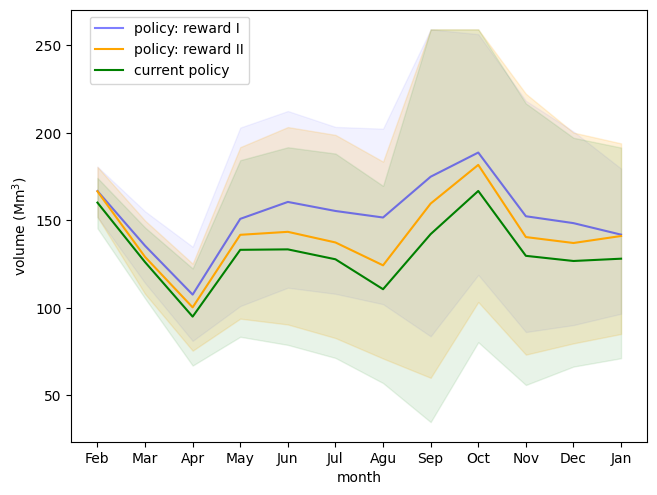

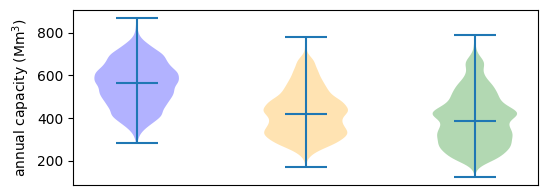

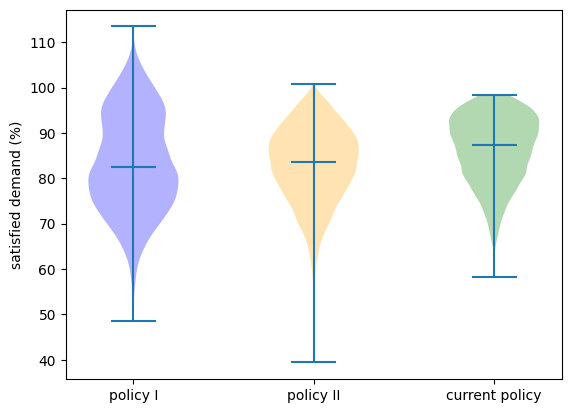

In [2]:
draw_evaluation(policy_m_ri_evaluation, policy_m_riii_evaluation, policy_default_evaluation)